## Retrieval ReRank

<a target="_blank" href="https://colab.research.google.com/github/microsoft/LLMLingua/blob/main/examples/Retrieval.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

We know that LLMs have a '**lost in the middle**' issue, where the position of key information in the prompt significantly impacts the final result. 

How to build an accurate positional relationship between the document and the question has become an important issue. We evaluated the effects of four types of reranker methods on a dataset (**NaturalQuestions Multi-document QA** that is very close to the actual RAG scenario, e.g. **BingChat**). 

The methods are **traditional Retrieval methods** (bm25, [gzip](https://aclanthology.org/2023.findings-acl.426/)), **embedding-based methods** ([sentence-bert](https://www.sbert.net/), [openai](https://platform.openai.com/docs/guides/embeddings), [bge](https://huggingface.co/BAAI/bge-large-en-v1.5), [voyageai](https://www.voyageai.com/), [jinza](https://huggingface.co/jinaai/jina-embeddings-v2-base-en)), **Reranker based methods** ([bge_reranker](https://huggingface.co/BAAI/bge-reranker-large), [bge_llmembedder](https://huggingface.co/BAAI/llm-embedder), [cohere](https://cohere.com/rerank)), and **Ours** (**LLMLingua**, **LongLLMIngua w/o restrictive**, **LongLLMLingua**).  

The results show that reranker-based methods are significantly better than embedding methods. The LongLLMLingua method is even better than the current SoTA reranker methods, and it can more accurately capture the relationship between the query and the document, thus alleviating the 'lost in the middle' issue.

## Setup

In [4]:
# Install dependency.
## Lost in the middle
!git clone https://github.com/nelson-liu/lost-in-the-middle
!cd lost-in-the-middle && echo "xopen" > requirements.txt && pip install -e .
## LLMLingu & Other
!pip install llmlingua sentence_transformers voyageai cohere

fatal: destination path 'lost-in-the-middle' already exists and is not an empty directory.
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/hjiang/Code/github/LLMLingua/examples/lost-in-the-middle
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for lost-in-the-middle (pyproject.toml) ... done
  Created wheel for lost-in-the-middle: filename=lost_in_the_middle-0.0.0-0.editable-py3-none-any.whl size=4612 sha256=8c165d20b34c175555284b514a54e16eb68cde5ee3903a6cb8ed76ae4496dac2
  Stored in directory: /tmp/pip-ephem-wheel-cache-jw34ldao/wheels/1e/ff/75/6c31681b19235602b007f32c4ec397e7e2eeacc2c76fcefcde
Successfully built lost-in-the-middle
  Attempting uninstall: lost-in-the-middle
    Found existing installation: lost-in-the-middle 0.0.0
    Uninstalling lost-in-

## Evaluate the Reranker Performance

In [ ]:
# Setup LLMLingua
from llmlingua import PromptCompressor

llm_lingua = PromptCompressor()

In [ ]:
import json

from xopen import xopen
from copy import deepcopy
from tqdm import tqdm

from lost_in_the_middle.prompting import (
    Document,
    get_qa_prompt,
)


def get_reranker_results(rank_method):
    path = "lost-in-the-middle/qa_data/20_total_documents/nq-open-20_total_documents_gold_at_9.jsonl.gz"
    d_idx = 9
    res = []
    with xopen(path) as f:
        for ii, jj in tqdm(enumerate(f), total=2655):
            input_example = json.loads(jj)
            question = input_example["question"]
            documents = []
            for ctx in deepcopy(input_example["ctxs"]):
                documents.append(Document.from_dict(ctx))

            prompt = get_qa_prompt(
                question,
                documents,
                mention_random_ordering=False,
                query_aware_contextualization=False,
            )

            c = prompt.split("\n\n")
            instruction, question = c[0], c[-1]
            demonstration = "\n".join(c[1:-1])
            corpus = demonstration.split("\n")

            idx = llm_lingua.get_rank_results(
                corpus,
                question,
                rank_method,
                "none" if rank_method == "llmlingua" else "after",
                [0] * 20,
            )
            idx = [ii[0] for ii in idx].index(d_idx)
            res.append(idx)
    logs = [rank_method]
    for idx in range(1, 21):
        acc = len([ii for ii in res if ii < idx]) / len(res) * 100
        print(
            "R@{},{:.2f}".format(
                idx, len([ii for ii in res if ii < idx]) / len(res) * 100
            )
        )
        logs.append("{:.2f}".format(acc))
    with open("retrieval.csv", "a") as f:
        f.write(",".join(logs) + "\n")


for rank_method in [
    "bm25",
    "gzip",
    "sentbert",
    "openai",
    "bge",
    "bge_reranker",
    "bge_llmembedder",
    "jinza",
    "voyageai",
    "cohere",
    "llmlingua",
    "longllmlingua",
]:
    get_reranker_results(rank_method)

## Plot the results

In [1]:
recall_str = open("retrieval.csv").read()
recall_list = [ii.split("\t") for ii in recall_str.split("\n\n")]
recall_list_data = [
    [ii[0], j + 1, float(k)] for ii in recall_list for j, k in enumerate(ii[1:])
]

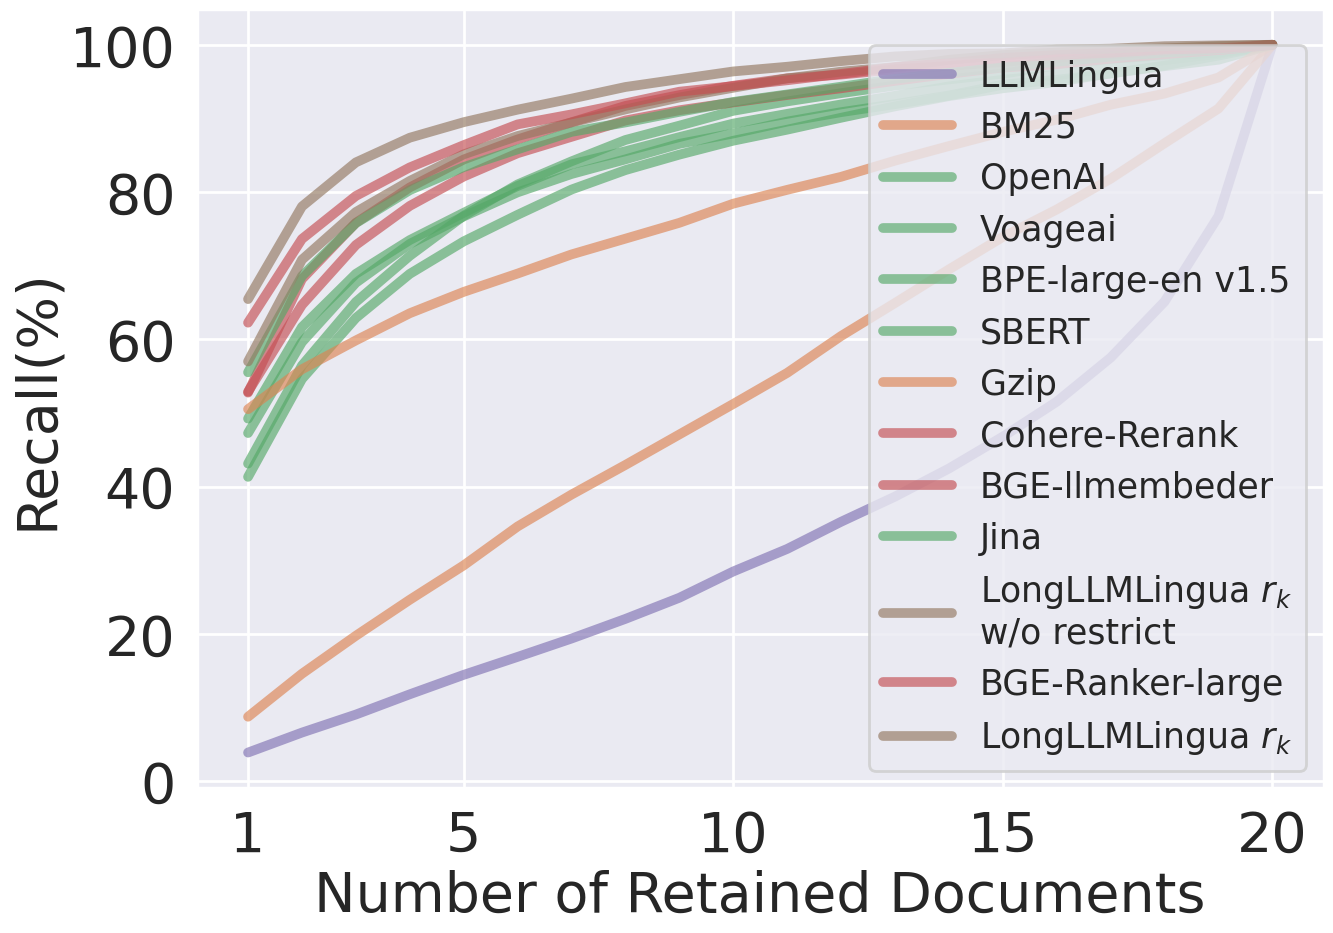

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme("poster", style="darkgrid", font_scale=1.2)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

# plt.rc('font', family="Times New Roman", size=30) #controls default text size
plt.rc("axes", titlesize=40)  # fontsize of the title
plt.rc("axes", labelsize=40)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=40)  # fontsize of the x tick labels
plt.rc("ytick", labelsize=40)  # fontsize of the y tick labels
plt.rc("legend", fontsize=25)  # fontsize of the legend

plt.figure(figsize=(14, 10))
pq = pd.DataFrame(recall_list_data)
pq.columns = ["Method", "k", "R@k"]

methods = [
    "LLMLingua",
    "BM25",
    "OpenAI",
    "Voageai",
    "BPE-large-en v1.5",
    "SBERT",
    "Gzip",
    "Cohere-Rerank",
    "BGE-llmembeder",
    "Jina",
    "LongLLMLingua $r_k$ \nw/o restrict",
    "BGE-Ranker-large",
    "LongLLMLingua $r_k$",
]
colors = ["4", "1", "2", "2", "2", "2", "1", "3", "3", "2", "5", "3", "5"]
markers = [">", "^", "s", "o", "<", ".", "*", ">", "^", "s", "o", "<", ".", "*"]
for m, c, ma in zip(methods, colors, markers):
    plt.plot(
        pq[pq["Method"] == m]["k"],
        pq[pq["Method"] == m]["R@k"],
        alpha=0.65,
        color=f"C{c}",
        #         marker=ma,
        label=m,
        linewidth=7,
        markersize=5 if ma == "*" else 5,
    )

plt.xlabel("Number of Retained Documents")
plt.ylabel("Recall(%)")
plt.xticks([1, 5, 10, 15, 20], labels=["1", "5", "10", "15", "20"])
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig("retrieval.pdf", dpi=1000)

plt.show()